# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Importing Dataset from Kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/blood-cells

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/blood-cells
License(s): other
  0% 0.00/108M [00:00<?, ?B/s]
100% 108M/108M [00:00<00:00, 1.39GB/s]


In [4]:
!unzip blood-cells.zip -d blood-cells

Streaming output truncated to the last 5000 lines.
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8

## Creating DataFrame with Imagepath and Label

In [5]:
Train_dir = '/content/blood-cells/dataset2-master/dataset2-master/images/TRAIN'
Test_dir = '/content/blood-cells/dataset2-master/dataset2-master/images/TEST'

Paths = [(Train_dir, []), (Test_dir, [])]

# Loop through each directory
for dir_path, data_list in Paths:
    for label in os.listdir(dir_path):
        label_path = os.path.join(dir_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                data_list.append([img_path, label])

Train_df = pd.DataFrame(Paths[0][1], columns=['filepath', 'label'])
Test_df = pd.DataFrame(Paths[1][1], columns=['filepath', 'label'])

print("Train:", Train_df.shape)
print("Test:", Test_df.shape)

Train: (9957, 2)
Test: (2487, 2)


In [6]:
Train_df.head()

,filepath,label
0,/content/blood-cells/dataset2-master/dataset2-...,MONOCYTE
1,/content/blood-cells/dataset2-master/dataset2-...,MONOCYTE
2,/content/blood-cells/dataset2-master/dataset2-...,MONOCYTE
3,/content/blood-cells/dataset2-master/dataset2-...,MONOCYTE
4,/content/blood-cells/dataset2-master/dataset2-...,MONOCYTE


## Number of Unique Classes

In [7]:
Train_df['label'].unique()

array(['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL'], dtype=object)

## Displaying some Images

In [8]:
def show_blood_cell_images(image_gen):
    class_indices = image_gen.class_indices
    classes = list(class_indices.keys())
    images, labels = next(image_gen)

    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = min(length, 25)

    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1) / 2  # Normalize if needed
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color="green", fontsize=14)
        plt.axis('off')

    plt.show()

Found 9957 images belonging to 4 classes.


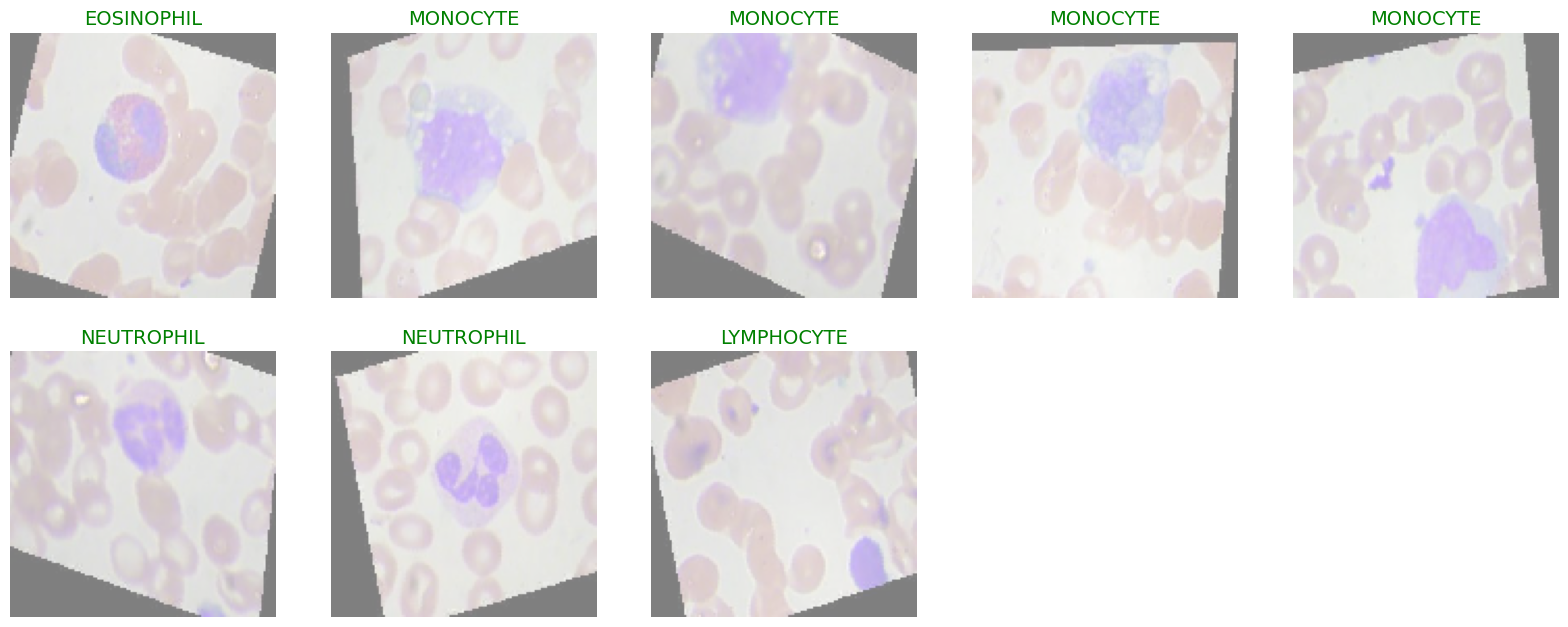

In [9]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    '/content/blood-cells/dataset2-master/dataset2-master/images/TRAIN',
    target_size=(128, 128),
    batch_size=8,
    class_mode='categorical',
    shuffle=True
)

show_blood_cell_images(train_generator)

##  Image Preprocessing with Data Generators

In [10]:
IMG_SIZE = 128

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=Train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=Train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=Test_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 7966 validated image filenames belonging to 4 classes.
Found 1991 validated image filenames belonging to 4 classes.
Found 2487 validated image filenames belonging to 4 classes.


## Model Training and Saving to Blood_Cell.h5

In [11]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze initially

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(4, activation='softmax', kernel_regularizer=l2(0.01))
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint('blood_cell.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.2584 - loss: 2.2475
Epoch 1: val_accuracy improved from -inf to 0.00100, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 62s 208ms/step - accuracy: 0.2585 - loss: 2.2466 - val_accuracy: 0.0010 - val_loss: 3.1909 - learning_rate: 1.0000e-04
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.3441 - loss: 1.7887
Epoch 2: val_accuracy improved from 0.00100 to 0.00201, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 42s 170ms/step - accuracy: 0.3442 - loss: 1.7885 - val_accuracy: 0.0020 - val_loss: 3.0067 - learning_rate: 1.0000e-04
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.3759 - loss: 1.6112
Epoch 3: val_accuracy improved from 0.00201 to 0.00251, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - accuracy: 0.3759 - loss: 1.6112 - val_accuracy: 0.0025 - val_loss: 3.1136 - learning_rate: 1.0000e-04
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.4123 - loss: 1.5066
Epoch 4: val_accuracy did not improve from 0.00251
249/249 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.4122 - loss: 1.5066 - val_accuracy: 0.0010 - val_loss: 3.1502 - learning_rate: 1.0000e-04
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4070 - loss: 1.4676
Epoch 5: val_accuracy improved from 0.00251 to 0.00452, saving model to blood_cell.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
249/249 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.4071 - loss: 1.4675 - val_accuracy: 0.0045 - val_loss: 3.0208 - learning_rate: 1.0000e-04
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.4324 - loss: 1.3997
Epoch 6: val_accuracy improved from 0.00452 to 0.00954, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 42s 168ms/step - accuracy: 0.4324 - loss: 1.3997 - val_accuracy: 0.0095 - val_loss: 2.9508 - learning_rate: 5.0000e-05
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.4273 - loss: 1.3743
Epoch 7: val_accuracy improved from 0.00954 to 0.01457, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.4273 - loss: 1.3743 - val_accuracy: 0.0146 - val_loss: 2.9036 - learning_rate: 5.0000e-05
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.4474 - loss: 1.3319
Epoch 8: val_accuracy improved from 0.01457 to 0.01959, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.4474 - loss: 1.3319 - val_accuracy: 0.0196 - val_loss: 2.8166 - learning_rate: 5.0000e-05
Epoch 9/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.4513 - loss: 1.3122
Epoch 9: val_accuracy improved from 0.01959 to 0.02109, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.4513 - loss: 1.3123 - val_accuracy: 0.0211 - val_loss: 2.7483 - learning_rate: 5.0000e-05
Epoch 10/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.4420 - loss: 1.3165
Epoch 10: val_accuracy did not improve from 0.02109
249/249 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.4421 - loss: 1.3164 - val_accuracy: 0.0211 - val_loss: 2.7677 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 9.
Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.4190 - loss: 1.3807
Epoch 1: val_accuracy improved from 0.02109 to 0.11602, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 119s 295ms/step - accuracy: 0.4191 - loss: 1.3803 - val_accuracy: 0.1160 - val_loss: 2.2278 - learning_rate: 1.0000e-05
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5746 - loss: 1.0442
Epoch 2: val_accuracy did not improve from 0.11602
249/249 ━━━━━━━━━━━━━━━━━━━━ 44s 178ms/step - accuracy: 0.5747 - loss: 1.0439 - val_accuracy: 0.1010 - val_loss: 2.5883 - learning_rate: 1.0000e-05
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6918 - loss: 0.7884
Epoch 3: val_accuracy improved from 0.11602 to 0.12205, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 45s 181ms/step - accuracy: 0.6919 - loss: 0.7883 - val_accuracy: 0.1220 - val_loss: 2.7488 - learning_rate: 1.0000e-05
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7565 - loss: 0.6381
Epoch 4: val_accuracy improved from 0.12205 to 0.24711, saving model to blood_cell.h5



Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
249/249 ━━━━━━━━━━━━━━━━━━━━ 46s 184ms/step - accuracy: 0.7565 - loss: 0.6381 - val_accuracy: 0.2471 - val_loss: 2.5161 - learning_rate: 1.0000e-05
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7952 - loss: 0.5715
Epoch 5: val_accuracy improved from 0.24711 to 0.31241, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 46s 184ms/step - accuracy: 0.7952 - loss: 0.5715 - val_accuracy: 0.3124 - val_loss: 2.2161 - learning_rate: 5.0000e-06
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8090 - loss: 0.5274
Epoch 6: val_accuracy improved from 0.31241 to 0.42140, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 46s 183ms/step - accuracy: 0.8090 - loss: 0.5274 - val_accuracy: 0.4214 - val_loss: 1.8047 - learning_rate: 5.0000e-06
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8278 - loss: 0.4861
Epoch 7: val_accuracy improved from 0.42140 to 0.50728, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 46s 186ms/step - accuracy: 0.8278 - loss: 0.4861 - val_accuracy: 0.5073 - val_loss: 1.5062 - learning_rate: 5.0000e-06
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8477 - loss: 0.4460
Epoch 8: val_accuracy improved from 0.50728 to 0.61125, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 46s 183ms/step - accuracy: 0.8477 - loss: 0.4460 - val_accuracy: 0.6113 - val_loss: 1.2339 - learning_rate: 5.0000e-06
Epoch 9/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8525 - loss: 0.4279
Epoch 9: val_accuracy improved from 0.61125 to 0.68659, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 45s 181ms/step - accuracy: 0.8525 - loss: 0.4279 - val_accuracy: 0.6866 - val_loss: 1.0084 - learning_rate: 5.0000e-06
Epoch 10/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8645 - loss: 0.4094
Epoch 10: val_accuracy improved from 0.68659 to 0.74485, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 46s 184ms/step - accuracy: 0.8645 - loss: 0.4094 - val_accuracy: 0.7449 - val_loss: 0.8000 - learning_rate: 5.0000e-06
Restoring model weights from the end of the best epoch: 10.


## Evaluating Model Performance on Test Data

In [12]:
model = load_model('blood_cell.h5')

test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.8705 - loss: 0.4657
Test Accuracy: 0.8219
Test Loss: 0.5832


## Plotting Model Accuracy and Loss

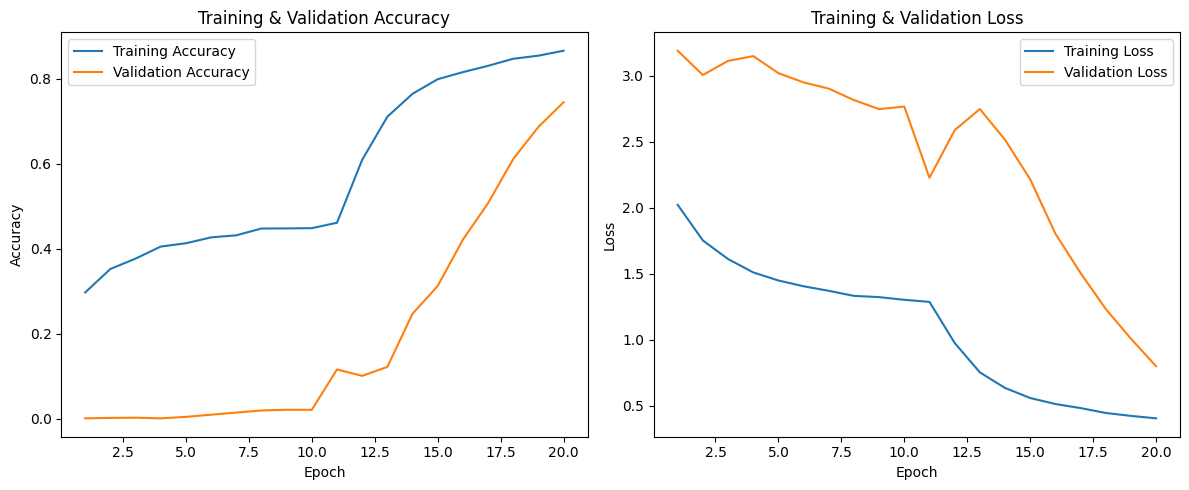

In [21]:
import matplotlib.pyplot as plt

# Combine metrics from both training phases
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc,  label='Training Accuracy')
plt.plot(epochs, val_acc,  label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss,  label='Training Loss')
plt.plot(epochs, val_loss,  label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Classification Report

In [14]:
y_test = test_gen.labels

pred2 = model.predict(test_gen)
pred2 = np.argmax(pred2, axis=1)

print(classification_report(y_test, pred2, target_names=test_gen.class_indices.keys()))
print("Accuracy of the Model:", "{:.1f}%".format(accuracy_score(y_test, pred2) * 100))

39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step
              precision    recall  f1-score   support

  EOSINOPHIL       0.93      0.56      0.70       623
  LYMPHOCYTE       0.78      1.00      0.87       620
    MONOCYTE       0.91      0.87      0.89       620
  NEUTROPHIL       0.74      0.85      0.79       624

    accuracy                           0.82      2487
   macro avg       0.84      0.82      0.82      2487
weighted avg       0.84      0.82      0.81      2487

Accuracy of the Model: 82.2%


# Confusion Matrix

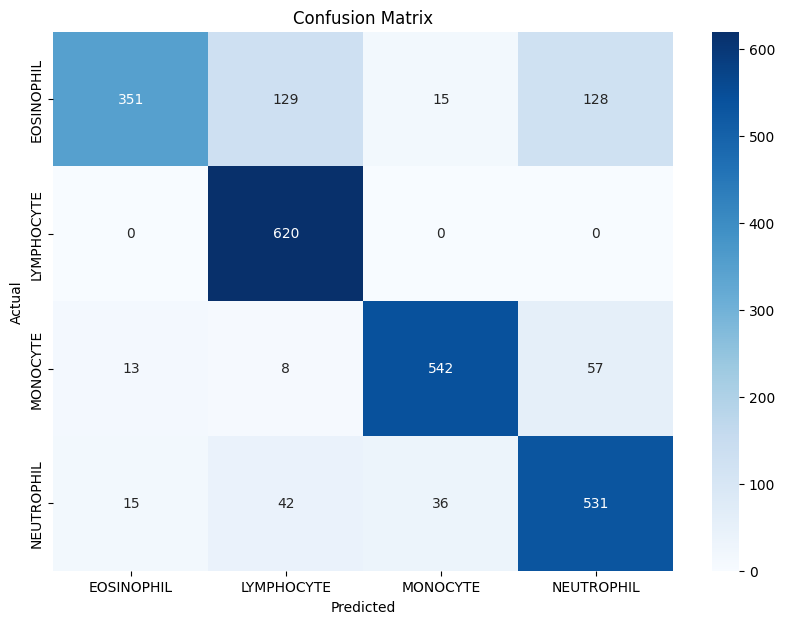

In [15]:
class_labels = list(test_gen.class_indices.keys())
cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Downloading Model saved as Blood_Cell.h5

In [16]:
from google.colab import files
files.download('blood_cell.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>